# Day 3 – Feature Engineering

Feature engineering is the process of transforming raw data into features that better represent the underlying problem. A thoughtful feature can be the difference between a mediocre model and a highly accurate one. Today, we'll create new features and prove their value.

## Load & Prepare Data

For simplicity in this notebook, we'll drop rows with any missing data.

In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Load data
mission_df = pd.read_csv("/Users/amrithaa/Downloads/12DayDataSeries/notebooks/data/mission_data.csv")
mission_df.head()

# Handle missing values by dropping rows for this analysis
df_clean = mission_df.dropna().copy()


## Part 1: Feature Engineering in Action

We will now engineer features in four new ways:

### A. Binning

Converting a continuous number into discrete categories can help models capture non-linear trends. 

In [330]:
# Binning mission durations
df_clean["duration_bin"] = pd.cut(
    df_clean["mission_duration_days"],
    bins=[0, 250, 750, np.inf],
    labels=["short", "medium", "long"]
)

### B. One-hot Encoding
Machine learning models require numeric input, so we convert categorical labels like `mission_type` and our new `duration_bin` into numbers using one-hot encoding.

In [331]:
# One-hot encode the 'mission_type' and 'duration_bin'
df_encoded = pd.get_dummies(df_clean, columns=["mission_type", "duration_bin"], drop_first=True)

### B. Scaling & Normalization

In [332]:
# Normalize numeric features
numeric_cols = [
    "crew_size", "distance_to_target_km", "fuel_capacity_kg", "solar_flare_risk",
    "mental_health_score",
]
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

# Save cleaned and engineered dataset for future use
df_encoded.to_csv("/Users/amrithaa/Downloads/12DayDataSeries/notebooks/data/encoded_data.csv", index=False)

This allows a model to learn, for example, that the jump in difficulty from a "medium" to a "long" mission is different than the jump from "short" to "medium."

### D. Synthetic Features
We'll combine three different sources of risk—solar flares, system anomalies, and poor crew health—into a single, more powerful feature.

In [333]:
# Scale components between 0 and 1
scaler = MinMaxScaler()
flare_scaled = scaler.fit_transform(df_encoded[["solar_flare_risk"]])
mh_scaled = scaler.fit_transform((1 - df_encoded[["mental_health_score"]]))  # Low mental health = more risk

# Weight anomaly less heavily due to class imbalance
risk_score = 0.4 * flare_scaled.flatten() + 0.4 * mh_scaled.flatten() + 0.2 * df_encoded["anomaly_detected"]

# Replace existing column
df_encoded["risk_score"] = risk_score

# Display sample of engineered DataFrame
df_encoded.head()

,mission_id,crew_size,mission_duration_days,distance_to_target_km,fuel_capacity_kg,payload_mass_kg,mental_health_score,solar_flare_risk,mission_cost_millions,anomaly_detected,mission_success_score,mission_outcome,mission_type_Rescue,mission_type_Resupply,duration_bin_medium,duration_bin_long,risk_score
0,MSN_0000,1.510717,1173.0,-0.337857,-0.202807,725.61,-1.067971,0.275503,254.79,0,80.82,Success,False,False,False,True,0.372033
2,MSN_0002,0.512963,1464.7,0.506320,0.345654,810.49,-0.118274,-1.488038,261.06,0,91.95,Success,False,False,False,True,0.163212
3,MSN_0003,1.510717,1833.2,1.359012,1.533623,1220.50,0.061196,-0.496851,574.26,0,82.80,Success,True,False,False,True,0.221974
4,MSN_0004,-0.484791,1678.2,1.026104,0.650320,927.37,0.681864,0.635935,290.14,0,87.37,Success,False,False,False,True,0.254985
5,MSN_0005,0.512963,1505.8,0.533220,0.780971,978.60,0.921158,0.983494,460.06,0,88.98,Success,True,False,False,True,0.261099


This new `risk_score` is more informative than any single risk factor alone. It provides a holistic view of the mission's danger level. 

# Visualize Feature Engineering Impact

Let's use correlation heatmaps to visually confirm our engineered data is a better predictor of success than the raw features it was made from.


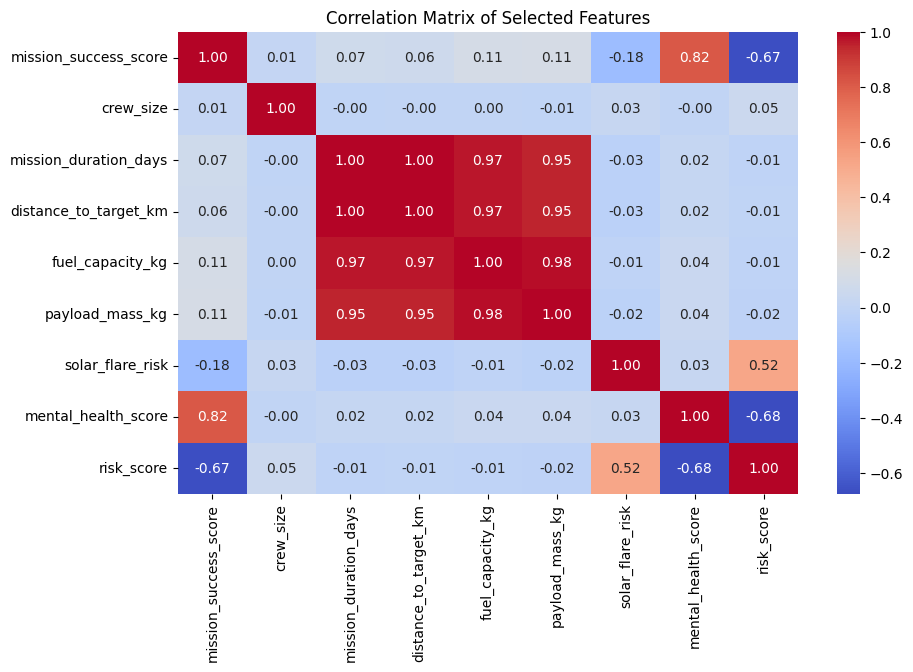

In [334]:
# Correlation heatmap of engineered features

# Select key features to visualize correlations
important_features = [
    'mission_success_score',           # Target variable
    'crew_size',
    'mission_duration_days',
    'distance_to_target_km',
    'fuel_capacity_kg',
    'payload_mass_kg',
    'solar_flare_risk',
    'mental_health_score',
    'risk_score',
]

# Create correlation matrix for selected features
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_encoded[important_features].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix of Selected Features")
plt.show()

The heatmap immediately reveals two critical insights: a challenge and an opportunity.

- **The Challenge**: Multicollinearity

The dark red square in the top-left indicates high multicollinearity. The features `mission_duration_days` and `distance_to_target_km` are almost perfectly correlated (1.00), as are their relationships with `fuel_capacity_kg` (0.97).

What this means: These features are redundant. Including them all in a model can make it unstable and hard to interpret, because the model struggles to decide which feature deserves credit. This is a classic problem that Regularization, which we'll cover on Day 4, is designed to solve.

- **The Opportunity**: Validating `risk_score`

While not the strongest single predictor, `risk_score` successfully consolidates multiple distinct factors (environmental, technical, and human) into a single, holistic metric. This allows a model to assess the overall mission danger with one number, which is often more practical than analyzing separate components.

## Part 2. Value of Feature Engineering

Now, let's prove that our new features improve model performance by will comparing a model using only raw features to one with our engineered features.

### Model 1: Baseline Model (Raw Features)

In [335]:
# Features available before engineering
features_raw = ['crew_size', 'distance_to_target_km', 'mission_duration_days', 'fuel_capacity_kg', 'solar_flare_risk', 'mental_health_score']
X_raw = df_encoded[features_raw]
y = df_encoded['mission_success_score']

model_raw = LinearRegression()
model_raw.fit(X_raw, y)

y_pred_raw = model_raw.predict(X_raw)

mse_raw = mean_squared_error(y, y_pred_raw)
r2_raw = r2_score(y, y_pred_raw)

print(f"MSE with Raw Features: {mse_raw:.2f}")
print(f"R2 with Raw Features: {r2_raw:.2f}")
print("Coefficients with Raw Features (High Multicollinearity):")
for feat, coef in zip(features_raw, model_raw.coef_):
    print(f"{feat:>25}: {coef:.2f}")


MSE with Raw Features: 27.78
R2 with Raw Features: 0.73
Coefficients with Raw Features (High Multicollinearity):
                crew_size: 0.18
    distance_to_target_km: -14.85
    mission_duration_days: 0.02
         fuel_capacity_kg: 5.48
         solar_flare_risk: -2.21
      mental_health_score: 8.23


### Model 2: Enhanced Model (Engineered Features)

In [336]:
# Using our new 'risk_score' and encoded categories
features_eng = [ # Drop highly correlated features, e.g., payload mass, distance, fuel capacity
    'risk_score', # Our composite feature
    'mission_type_Resupply', 'mission_type_Rescue', # Encoded features
    'duration_bin_medium', 'duration_bin_long', 'mental_health_score' # Still include mental health due to the high correlation
]
X_eng = df_encoded[features_eng]

model_eng = LinearRegression()
model_eng.fit(X_eng, y)
y_pred_eng = model_eng.predict(X_eng)
mse_eng = mean_squared_error(y, y_pred_eng)
r2_eng = r2_score(y, y_pred_eng)

print(f"MSE with Engineered Features: {mse_eng:.2f}")
print(f"R2 with Raw Features: {r2_eng:.2f}")
print("\n Coefficients with Engineered Features (Reduced Redundancy):")
for feat, coef in zip(features_eng, model_eng.coef_):
    print(f"{feat:>25}: {coef:.2f}")



MSE with Engineered Features: 19.57
R2 with Raw Features: 0.81

 Coefficients with Engineered Features (Reduced Redundancy):
               risk_score: -18.24
    mission_type_Resupply: 5.82
      mission_type_Rescue: -3.58
      duration_bin_medium: -0.13
        duration_bin_long: 1.80
      mental_health_score: 6.68


## Analysis & Takeaways

The Result is Clear: The model using our engineered features achieved a significantly lower MSE (Mean Squared Error) than the baseline model. This means its predictions are, on average, closer to the true mission success scores.

- Consolidated Features are Powerful: Creating the `risk_score` concentrated multiple weak signals into one predictor, which directly lowered the model's prediction error.

- Models Can Learn from Categories: By encoding `mission_type`, we allowed the linear model to learn from non-numeric information, further improving its accuracy.

**Takeway**: Feature engineering is where data science meets creativity. By thoughtfully transforming data, we build smarter, more accurate models.

📌 Next up: Day 4 – Regularization & Cross-Validation
Our model now uses many features. How do we manage this complexity and ensure our model is robust? Next, we'll learn Regularization techniques to prevent overfitting and Cross-Validation to measure our model's true performance.